### How To: Reduce Friction and Save Time with Tangermeme

As a researcher, one of your most valuable resources is time and, consequently, one of your worst enemies is *friction*. Every time you encounter a stupid error message doing something basic, or a function takes much longer to run than you think it should, or you have to write the same boilerplate code over and over again, you create a small drag on your research project. When these add up, projects can take significantly longer than they should and, sometimes, you even feel dread even working on the project because it takes so much effort to make progress. These frictions are particularly annoying when they are very technical in nature and you are not a technical person. As an example that we were explore more deeply soon, something as simple as making predictions from a PyTorch model can have several sources of friction: making sure the tensors are on the same device, that they have the same dtype, that you don't run out of memory, etc. Having to check each one of these -- or having to debug your code when one of these are violated -- can require context switches that bog down progress on the interesting scientific questions that you have. 

Reducing these sources of friction is a core motivation behind tangermeme, and we take a three pronged approach to ironing out frictions. First, we provide fast implementations of core functions so you spend less time waiting around for things to finish. I will use the one-hot encoding function as an example. Second, we provide comprehensive implementations of functions that are safe so you do not have to think about the boring boilerplate code or edge cases. Finally, we stack commonly-used functions together so you can go from models and data directly to results using far fewer lines that you might normally need. I will demonstrate one such stack where we combine the calculation and plotting of attributions using several models.

#### One-Hot Encodings

An important way that tangermeme reduces friction is by being very fast. This means that instead of having to wait several seconds for some operations to finish -- giving you time to be alone with your thoughts -- you can keep going and not lose your train of thought. Although most operations in tangermeme will be limited by the speed of the underlying model, there are some important operations that are model independent. For example, almost everyone needs one-hot encodings to convert sequences of characters into a tensor that is then fed into the model. This function is conceptually simple because all it requires is mapping the identity of the character to an index in the tensor. But there are a few speed optimizations that can *significantly* speed up this operation that some people may be unaware of. Further, some of the speed optimizations that are used can require allocating memory for intermediary arrays, which inadvertantly holds them back. In contrast, tangermeme's implementation is fast and does not require any intermediary memory allocations.

Let's start off by taking a look at a 40M nucleotide chunk from chr1.

In [1]:
import pyfaidx

chrom, mid = 'chr1', 100_000_000
start, end = mid - 20_000_000, mid + 20_000_000

X = pyfaidx.Fasta("../../../../common/hg38.fa")['chr1'][start:end].seq.upper()
len(X)

40000000

As a simple baseline, we can include a function that is likely the simplest one-hot encoding implementation. This is by nowhere near the fastest non-tangermeme implementation out there for doing one-hot encodings, but I think it is likely the most-used one (or within the ballpark of the most-used one) due to this simplicity. Basically, the function pre-allocates a numpy array and iterates through each character in the sequence, filling in the corresponding entry with a 1.

In [2]:
import numpy

def slow_one_hot_encode(seq):
    X = numpy.zeros((4, len(seq)))
    
    for i, char in enumerate(seq):
        if char == 'A':
            X[0, i] = 1
        elif char == 'C':
            X[1, i] = 1
        elif char == 'G':
            X[2, i] = 1
        elif char == 'T':
            X[3, i] = 1
    
    return X

As a technical note, indexing into numpy arrays can be ~2-10x faster than indexing into PyTorch tensors. Even if you ultimately want a PyTorch tensor, make sure you do indexing like the above function does in numpy and then subsequently convert the `numpy.ndarray` to a `torch.Tensor`, as we do here.

Now we can time this implementation against tangermeme's implementation of the same operation. Note that we are not including the time that it takes to read the FASTA file or convert all the characters to upper case (not that this second part is a significant amount of time).

In [3]:
from tangermeme.utils import one_hot_encode

%timeit -r 3 -n 1 slow_one_hot_encode(X)
%timeit -r 3 -n 1 one_hot_encode(X)

6.34 s ± 33 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
121 ms ± 2.03 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Looks like tangermeme is a bit over ~30x faster and takes less than one second, putting it in that nice spot of not interrupting interactive work.

We can push this further, though. How long does it take tangermeme to one-hot encode the ~249M nucleotide chr1?

In [4]:
X = pyfaidx.Fasta("../../../../common/hg38.fa")['chr1'][:].seq.upper()

%timeit one_hot_encode(X)

716 ms ± 361 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Tangermeme can one-hot encode the entirety of chr1 ~6x faster than our simple implementation could encode a 40M chunk of it.

#### Prediction
##### Basics

In theory, making predictions from PyTorch models is very simple. After all, it's just `model(X)`, right? However, if you're anything like me, around half the time you go to make predictions using that command you encounter an error. And if you are not careful, you can get incorrect results without even realizing it.

<i>Note: the following cells intentionally have many errors in them. You will need to manually run the notebook.</i>

Let's imagine the situation where all we want to do is make predictions at some single locus. First, we can load it and make sure it is the right shape.

In [5]:
chrom, mid = 'chr12', 1027000
start, end = mid - 1057, mid + 1057

X = pyfaidx.Fasta("../../../../common/hg38.fa")['chr1'][start:end].seq.upper()
X = one_hot_encode(X)[None]
X.shape

torch.Size([1, 4, 2114])

Then we can load our model. Here, we are loading a BPNet model that makes predictions for CTCF, but the specifics of the model do not matter yet.

In [6]:
import torch

from bpnetlite.bpnet import ControlWrapper
from bpnetlite.bpnet import CountWrapper

model = torch.load("../../../../models/bpnet/CTCF.torch", weights_only=False)
model = CountWrapper(ControlWrapper(model))

Now, let's just apply `model(X)` to make predictions!

In [7]:
model(X)

RuntimeError: Input type (signed char) and bias type (float) should be the same

Error! The one-hot encodings that are returned by tangermeme's `one_hot_encode` function are of dtype `uint8` (called "signed char") for compression reasons.

That's annoying. But at least we can easily fix it, right? Let's just cast `X` as floats.

In [8]:
model(X.float())

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper_CUDA___slow_conv2d_forward)

Error! Our model was saved to the GPU and so was automatically loaded to the GPU but our one-hot encoded sequence was never moved to the GPU. 

Okay.. so we need to cast our data as floats and we also need to move it to the GPU.

In [9]:
model(X.float().cuda())

tensor([[0.0183]], device='cuda:0', grad_fn=<ViewBackward0>)

Great, now it runs. I have encountered one or another of these issues so many times, though, and each time it has thrown me off my train of thought. When this happens in a notebook it may not be as bad because you can just fix the issue, but I have also encountered these issues repeatedly when writing longer running scripts and just had the entire job die.

But this is not the extent of the issues. Let's say that you want to try running everything at half precision instead of full precision because you heard that half precision can be faster without being meaningfully different.

In [10]:
model(X.half().cuda())

RuntimeError: Input type (c10::Half) and bias type (float) should be the same

Error! You converted the data to half precision but you kept the model at full precision. You have to move both over to do half precision.

In [11]:
model.half()(X.half().cuda())

tensor([[0.0179]], device='cuda:0', dtype=torch.float16,
       grad_fn=<ViewBackward0>)

Great, okay looks like that is working and the results are not significantly different than before.

But now let's say that you tried the above in a notebook and you did not like the loss of precision and so you want to go back to doing everything at full precision so you go back to the same command as before.

In [12]:
model(X.float().cuda())

RuntimeError: Input type (float) and bias type (c10::Half) should be the same

Error! When you converted the model to half precision you were not creating a second copy of the model that was kept temporarily for just that one operation. Rather, you were converting the entire model to half precision and this conversion lasted past that one operation. In order to fix it, you now need to convert the model back to full precision too.

In [13]:
model.float()(X.float().cuda())

tensor([[0.0181]], device='cuda:0', grad_fn=<ViewBackward0>)

In contrast to all of this, tangermeme's `predict` function allows you to pass in tensors and models that live on any device and are of any datatype and will move everything over to the specified device (default `cuda`) and convert everything to the specified dtype (default `float32`).

In [14]:
from tangermeme.predict import predict

predict(model, X), predict(model, X, device='cpu'), predict(model, X, dtype='float16')

/users/jacob.schreiber/anaconda3/lib/python3.12/site-packages/torch/amp/autocast_mode.py:283: UserWarning: In CPU autocast, but the target dtype is not supported. Disabling autocast.
CPU Autocast only supports dtype of torch.bfloat16, torch.float16 currently.
  warnings.warn(error_message)


(tensor([[0.0181]]),
 tensor([[0.0181]]),
 tensor([[0.0179]], dtype=torch.float16))

All of this friction is now gone. You do not need to worry about what dtype your data is or where your model is living. Everything gets handled under the hood.

##### Large-scale Predictions and Batching

Frequently, one does not simply want to make a single prediction as we did before, but wants to make tons of predictions, e.g. across thousands of peaks. This scale can easily become larger than what fits in GPU memory at one time. Because `model(X)` applies the model to a single tensor, it will return an out of memory error if `X` is too large.

In [15]:
from tangermeme.utils import random_one_hot

X = random_one_hot((10000, 4, 2114), random_state=0).float().cuda()
#model.float()(X)    # This will raise an out of memory error. 
                     # However, due to the nature of out of memory errors, all the subsequent cells will also error out.
                     # So, we are leaving it for you to try if you would like. 

The natural solution to this out of memory error is to make predictions in batches where each batch fits in memory. A standard way to implement batching is to create a loop that slices out the batch of data, moves just that batch of data over to the GPU, makes predictions using the model, and moves the results back over to the CPU. Make sure that you do not miss the final examples if that batch is smaller than the batch size, though! And, of course, remember to concatenate the predictions together afterward and properly handle this concatenation operation when the model makes predictions for multiple outputs.

Of course, one could implement all of this logic yourself and test everything to make sure it is working properly. But that's additional friction and surface area for potential bugs to arise. Wouldn't it be easier to just use the built-in `predict` function which handles batching for you?

In [16]:
predict(model, X), predict(model, X, batch_size=4)

(tensor([[0.2230],
         [1.5555],
         [0.5225],
         ...,
         [0.7615],
         [0.0623],
         [0.1173]]),
 tensor([[0.2230],
         [1.5555],
         [0.5225],
         ...,
         [0.7615],
         [0.0623],
         [0.1173]]))

A nice feature of this implementation is that each batch is converted to the desired dtype. This means that (1) you can easily try out half precision without having to convert your entire dataset over, and (2) you can store your one-hot encodings in a compressed `uint8` format in CPU memory and only convert each batch to full precision. This second point can become very important when working on machines that have limited memory or when working with massive numbers of examples (e.g., trying to make predictions genome-wide).

In [17]:
predict(model, X.to(torch.uint8))

tensor([[0.2230],
        [1.5555],
        [0.5225],
        ...,
        [0.7615],
        [0.0623],
        [0.1173]])

##### Inconsistent/Incorrect Predictions

Potentially, a more important issue when making predictions is that certain layers may yield non-deterministic predictions. Specifically, dropout layers and some normalization layers have to be turned from training model to evaluation mode before one makes predictions, or the model will make different predictions each time even when given the same data. Although this sort of stochasticity can be helpful when training the models, you have to make sure that you turn it off before making predictions or else your results will not be reproducible (and will likely be worse).

Let's see this in action with Beluga, which has a dropout layer in it.

In [18]:
import sys
sys.path.append("/users/jacob.schreiber/models/deepsea")
from beluga import Beluga

class BelugaWrapper(torch.nn.Module):
    def __init__(self, model, target):
        super(BelugaWrapper, self).__init__()
        self.model = model
        self.target = target
    
    def forward(self, X):
        return self.model(X)

beluga_ = Beluga()
beluga_.load_state_dict(torch.load("../../../../models/deepsea/deepsea.beluga.pth", weights_only=False))
beluga = BelugaWrapper(beluga_, target=149).cuda()
beluga

BelugaWrapper(
  (model): Beluga(
    (model): Sequential(
      (0): Sequential(
        (0): Conv2d(4, 320, kernel_size=(1, 8), stride=(1, 1))
        (1): ReLU()
        (2): Conv2d(320, 320, kernel_size=(1, 8), stride=(1, 1))
        (3): ReLU()
        (4): Dropout(p=0.2, inplace=False)
        (5): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0, dilation=1, ceil_mode=False)
        (6): Conv2d(320, 480, kernel_size=(1, 8), stride=(1, 1))
        (7): ReLU()
        (8): Conv2d(480, 480, kernel_size=(1, 8), stride=(1, 1))
        (9): ReLU()
        (10): Dropout(p=0.2, inplace=False)
        (11): MaxPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0, dilation=1, ceil_mode=False)
        (12): Conv2d(480, 640, kernel_size=(1, 8), stride=(1, 1))
        (13): ReLU()
        (14): Conv2d(640, 640, kernel_size=(1, 8), stride=(1, 1))
        (15): ReLU()
      )
      (1): Sequential(
        (0): Dropout(p=0.5, inplace=False)
        (1): Lambda()
        (2): Sequential(
 

Now, let's make some random sequence and look at what Beluga's predictions are for it. Remember that Beluga makes 2,002 predictions for each sequence and so each number are its predictions for this one sequence for a different output. 

In [19]:
X = random_one_hot((1, 4, 2000), random_state=0).float().cuda()

beluga(X)

tensor([[-1.8312, -1.6030, -1.8890,  ..., -3.4361, -2.6254, -2.9689]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

Now let's run the same prediction function on the same sequence again.

In [20]:
beluga(X)

tensor([[-2.4094, -2.5310, -2.5081,  ..., -4.1933, -2.1046, -3.4884]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

Looks like it's different. Each time you make a prediction with the model like this you will get a different result.

tangermeme will automatically use `.eval()` on models when making predictions.

In [21]:
predict(beluga, X)

tensor([[-2.1377, -2.2490, -2.3604,  ..., -3.5702, -1.6757, -3.4082]])

In [22]:
predict(beluga, X)

tensor([[-2.1377, -2.2490, -2.3604,  ..., -3.5702, -1.6757, -3.4082]])

You might not think it is a big deal to have to call `.eval()`, and you're right. But that is only if you know that this might be an issue. And even if you do know that it might be an issue, having to remember to call `.eval()` each time you make predictions, in every single analysis you do, can be an annoying source of friction that is now automatically taken care for you. You do not even need to check to see whether the model might have stochastic layers -- tangermeme takes care of all of it for you.

#### Attribution + Plotting

In our first example we saw how a nice implementation of a basic function can smooth out a lot of frictions. Now, we will take a look at how stacking several functions on top of each other can make interactive exploration faster. Specifically, we will combine an attribution function and a plotting function to quickly go from one or more sequences and one or more models to attributions visualized in a manner that can be easily considered.

Let's start off by loading up the MAX promoter.

In [23]:
chrom, mid = 'chr14', 65_102_695 # MAX gene
start, end = mid - 1057, mid + 1057

X = pyfaidx.Fasta("../../../../common/hg38.fa")[chrom][start:end].seq.upper()
X = one_hot_encode(X)[None].float().cuda()
X.shape

torch.Size([1, 4, 2114])

Next, let's load up a series of models that we might want to use to dissect a locus. These models will include a series of BPNet models that each predict the binding of an individual TF, a ChromBPNet model that predict chromatin accessibility, and finally a ProCapNet model that predicts transcription initiation. Each one of these models provides a different lense with which to consider a sequence.

In [24]:
from bpnetlite import BPNet

gata_bpnet = torch.load("../../../../models/bpnet/GATA2.torch", weights_only=False)
gata_bpnet = CountWrapper(ControlWrapper(gata_bpnet))

myc_bpnet = torch.load("../../../../models/bpnet/MYC.torch", weights_only=False)
myc_bpnet = CountWrapper(ControlWrapper(myc_bpnet))

ctcf_bpnet = torch.load("../../../../models/bpnet/CTCF.torch", weights_only=False)
ctcf_bpnet = CountWrapper(ControlWrapper(ctcf_bpnet))

chrombpnet = BPNet.from_chrombpnet("../../../../models/chrombpnet/fold_0/model.chrombpnet_nobias.fold_0.ENCSR868FGK.h5")
chrombpnet = CountWrapper(chrombpnet)

procapnet = BPNet(512, n_outputs=2, n_control_tracks=0)
procapnet.load_state_dict(torch.load("../../../../models/procapnet/procapnet_model.fold0.torch", weights_only=False))
procapnet = CountWrapper(procapnet)

Now, we can calculate attribution values for each model on the same sequence.

In [25]:
from tangermeme.deep_lift_shap import deep_lift_shap

X_attrs = []
models = [gata_bpnet, myc_bpnet, ctcf_bpnet, chrombpnet, procapnet]

for model in models:
    X_attr_ = deep_lift_shap(model, X, random_state=0)
    X_attrs.append(X_attr_)

X_attrs = torch.cat(X_attrs)
X_attrs.shape

torch.Size([5, 4, 2114])

Finally, we can plot each of these attributions using the `plot_logo` command.

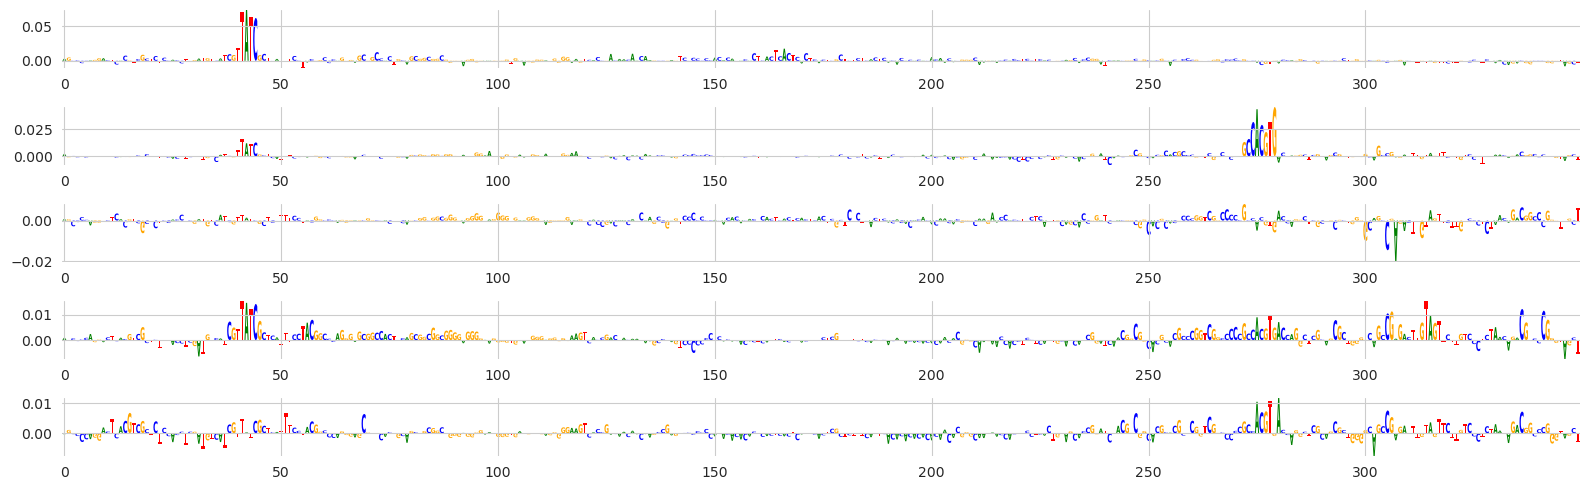

In [26]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn; seaborn.set_style('whitegrid')
from tangermeme.plot import plot_logo

start, end = 650, 1000


plt.figure(figsize=(16, 5))
ax = plt.subplot(511)
plot_logo(X_attrs[0, :, start:end], ax=ax)

ax = plt.subplot(512)
plot_logo(X_attrs[1, :, start:end], ax=ax)

ax = plt.subplot(513)
plot_logo(X_attrs[2, :, start:end], ax=ax)

ax = plt.subplot(514)
plot_logo(X_attrs[3, :, start:end], ax=ax)

ax = plt.subplot(515)
plot_logo(X_attrs[4, :, start:end], ax=ax)

plt.tight_layout()
plt.show()

Great! The results look interesting. Seems like the GATA motif is driving GATA predictions (in the first row) and accessibility (in the fourth row), which makes sense. Seems like a MYC::MAX motif is driving MYC predictions and also may be relevant for ProCapNet predictions (though it is not very clear). It also seems like CTCF is not particularly relevant at this locus, which also makes sense because CTCF binding is fairly simple and there is no CTCF motif here.

But this took a few lines of code. We had to, first, run attributions for each of the models, then concatenate them, and then plot each one of the subplots, making sure to slice out the same region from each of the attributions.

We can reduce this friction by replacing the entirety of the last two code cells with a single call to `plot_attributions`, which will calculate attributions for each of the models on the given sequences and also plot them. If you're interested, it also returns both the attributions and the subplots in case you want to inspect the attributions more or if you want to annotate the subplots.

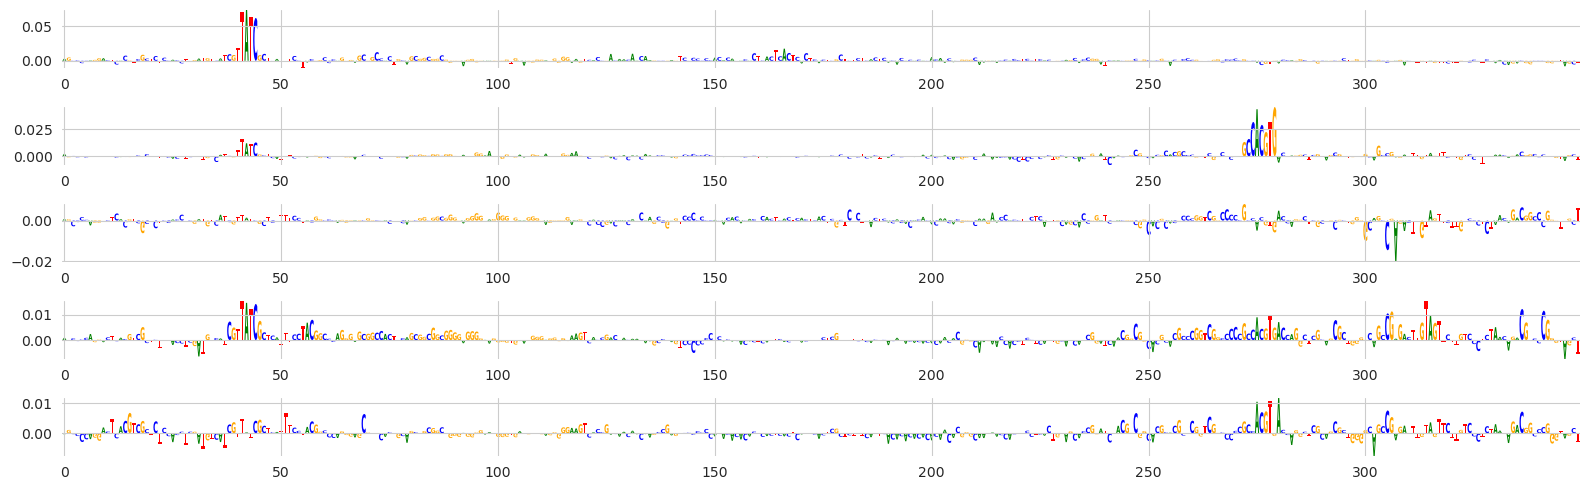

In [27]:
from tangermeme.plot import plot_attributions

plt.figure(figsize=(16, 5))
plot_attributions(models, X.repeat(5, 1, 1), plot_kwargs={'start': start, 'end': end}, attribute_kwargs={'random_state': 0})

plt.tight_layout()
plt.show()

Looks like we get the exact same plot. But, instead of needing to write all of those lines and make sure that they are correct, we can just use a single line. This has saved a bunch of time from me just not having to write this boilerplate code over and over again.

#### Conclusions

tangermeme is not a library that was built to be full of novel algorithms or state-of-the-art methods. Rather, it was built to reduce friction. Every line of code that you write is a line you have to think about, spend time writing, and then worry about because there could be a bug. Even when you think that the lines of code you are writing implement something easy, it can be helpful to abstract out that code to another implementation just so you do not have to think about it anymore and can instead focus on doing important science. 